In [1]:
import numpy as np
from pathlib import Path
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import random


np.random.seed(42)
random.seed(42)

In [ ]:
data = []
labels = []

for subject_dir in sorted(Path("archive").glob("s*"), key=lambda p: int(p.name[1:])):
    label = int(subject_dir.name[1:])
    for img_path in sorted(subject_dir.glob("*.pgm"), key=lambda p: int(p.stem)):
        img = imageio.imread(img_path)
        data.append(img.flatten())
        labels.append(label)


data_matrix = np.array(data)
label_vector = np.array(labels)

In [25]:
train_data = data_matrix[::2]  # Start = 0, Step = 2
test_data = data_matrix[1::2]  # Start = 1, Step = 2

train_labels = label_vector[::2]  # Start = 0, Step = 2
test_labels = label_vector[1::2]  # Start = 1, Step = 2


In [ ]:
data_centered = data_matrix - np.mean(data_matrix, axis=0)
cov_matrix = np.cov(data_centered, rowvar=False)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Save eigenvalues to file
np.savez('eigenvalues_eigenvectors.npz', eigenvalues=eigenvalues, eigenvectors=eigenvectors)

In [ ]:
class PCA:
    def __init__(self, eigenvalues=None, eigenvectors=None,  n_components=None, variance_threshold=None):
        self.n_components = n_components
        self.variance_threshold = variance_threshold
        self.components = None
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors
        self.mean = None 
        self.explained_variance_ratio = None
    
    def fit(self, X):        
        idx = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[idx]
        self.eigenvectors = self.eigenvectors[:, idx]
        
        total_variance = np.sum(self.eigenvalues)
        self.explained_variance_ratio = self.eigenvalues / total_variance
        
        if self.variance_threshold:
            cumulative_variance = np.cumsum(self.explained_variance_ratio)
            n_components = np.searchsorted(cumulative_variance, self.variance_threshold) + 1
            self.n_components = min(n_components, X.shape[1])
        elif self.n_components is None:
            self.n_components = X.shape[1]
        
        self.components = self.eigenvectors[:, :self.n_components]
        
        return self
    
    def transform(self, X):
        X_centered = X - self.mean
        
        X_transformed = np.dot(X_centered, self.components)
        
        return X_transformed
    
    def inverse_transform(self, X_transformed):
        X_reconstructed = np.dot(X_transformed, self.components.T) + self.mean
        
        return X_reconstructed

Retained components: 44


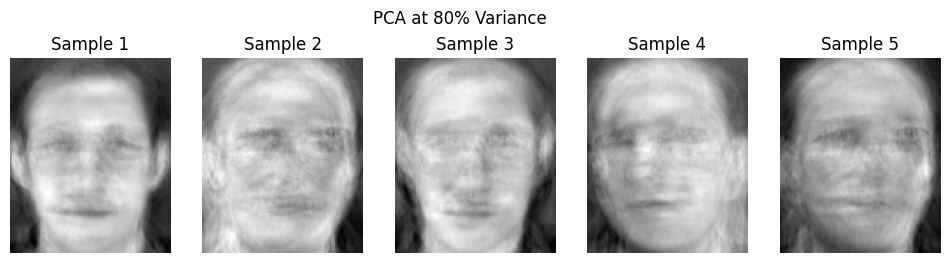

Retained components: 68


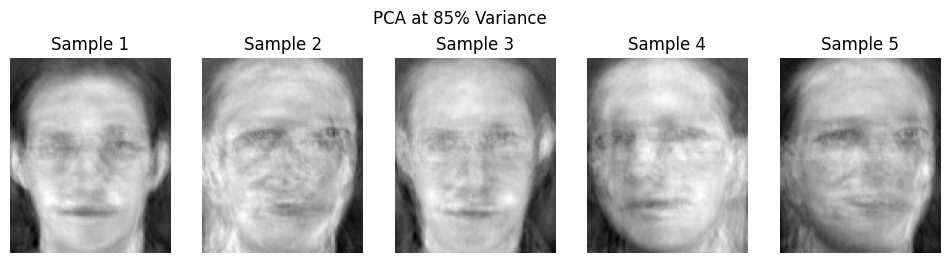

Retained components: 111


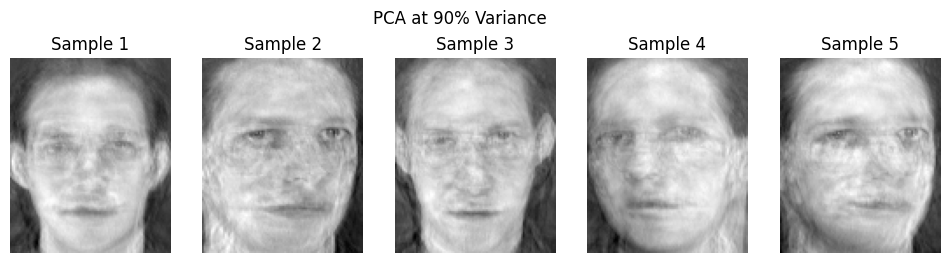

Retained components: 190


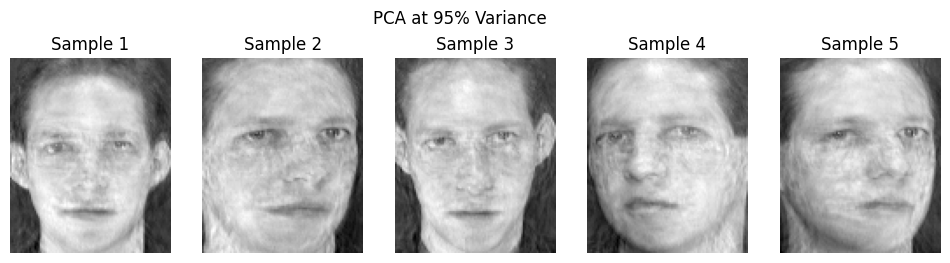

In [ ]:
data = np.load('eigenvalues_eigenvectors.npz')

evalues = data['eigenvalues']
evectors = data['eigenvectors']

alphas_values = [0.8, 0.85, 0.9, 0.95]

for alpha in alphas_values :
    pca = PCA(eigenvalues=evalues, eigenvectors=evectors, variance_threshold=alpha)

    pca.mean = np.mean(data_matrix, axis=0)
    pca.fit(data_matrix)

    print(f"Retained components: {pca.n_components}")
    
    train_pca = pca.transform(data_matrix)

    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i, ax in enumerate(axes):
        img = train_pca[i].reshape(1, -1)
        reconstructed = pca.inverse_transform(img).reshape(112, 92)
        ax.imshow(reconstructed, cmap='gray')
        ax.set_title(f"Sample {i+1}")
        ax.axis('off')
    plt.suptitle(f"PCA at {alpha*100:.0f}% Variance")
    plt.show()

In [ ]:
class KMeans:
    def __init__(self, n_clusters, max_iters=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None
    
    def fit(self, X):
        idx = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.centroids = X[idx]
        
        for _ in range(self.max_iters):
            distances = self._calculate_distances(X)
            new_labels = np.argmin(distances, axis=1)
            
            if hasattr(self, 'labels') and np.all(self.labels == new_labels):
                break
            
            self.labels = new_labels
            
            for i in range(self.n_clusters):
                points = X[self.labels == i]
                if len(points) > 0:
                    self.centroids[i] = np.mean(points, axis=0)
        
        return self
    
    def predict(self, X):
        distances = self._calculate_distances(X)
        return np.argmin(distances, axis=1)
    
    def _calculate_distances(self, X):
        distances = np.zeros((X.shape[0], self.n_clusters))
        
        for i, centroid in enumerate(self.centroids):
            distances[:, i] = np.linalg.norm(X - centroid, axis=1)
        
        return distances